<a href="https://colab.research.google.com/github/PatrizioMandelli/PyTorch-Course/blob/main/5_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Datasets**

We want to import an image dataset in PyTorch.

**1) Getting data**

In [14]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
#A dataset containing images of pizza, steack and sushi
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#Creating directory
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

#Downloading data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading")
  f.write(request.content)

#Unzipping data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.
Downloading
Unzipping


**2) Data exploration**

In [16]:
#Number of data files
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    if len(filenames) != 0:
      print(f"{dirpath}: {len(filenames)} images")

walk_through_dir(image_path)

data/pizza_steak_sushi/test/steak: 19 images
data/pizza_steak_sushi/test/pizza: 25 images
data/pizza_steak_sushi/test/sushi: 31 images
data/pizza_steak_sushi/train/steak: 75 images
data/pizza_steak_sushi/train/pizza: 78 images
data/pizza_steak_sushi/train/sushi: 72 images


In [17]:
#Defining training and testing data paths
train_dir = image_path / "train"
test_dir = image_path / "test"

In [18]:
#Finding calsses
class_names = os.listdir(train_dir)
class_names

['steak', 'pizza', 'sushi']

Random image path: data/pizza_steak_sushi/train/pizza/2885796.jpg
Random image class: pizza
Image size: (512, 512)


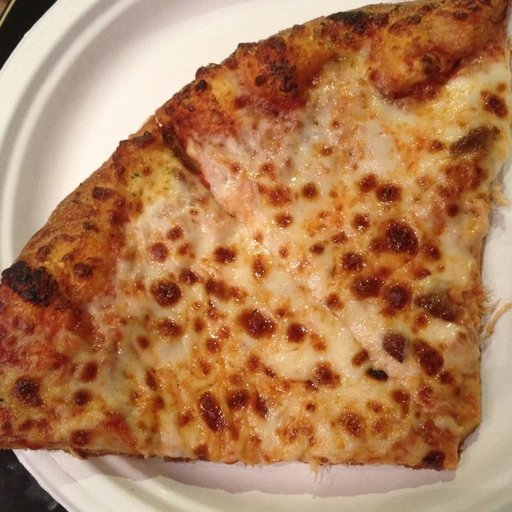

In [19]:
#Visualizing image data with PIL
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Image size: {img.size}")
img

(-0.5, 511.5, 511.5, -0.5)

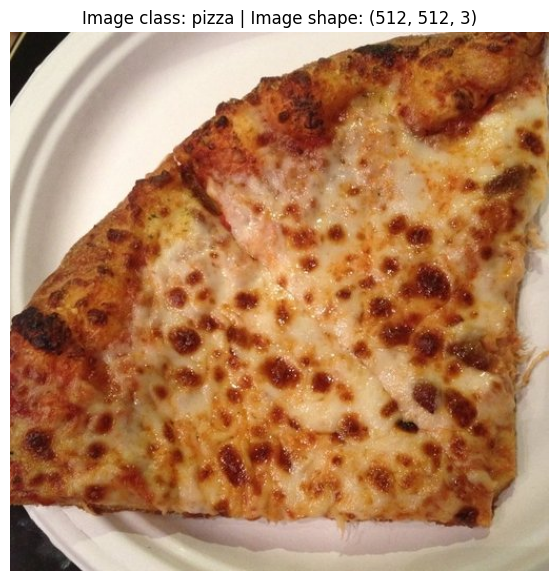

In [20]:
#Visualizing image data with matplotlib
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

**3) Data into tensors**

In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

*transform*

In [22]:
#Transforming data with transforms
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
    ])

img.size, data_transform(img).shape

((512, 512), torch.Size([3, 64, 64]))

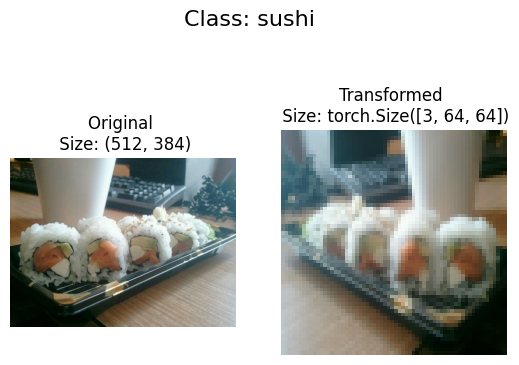

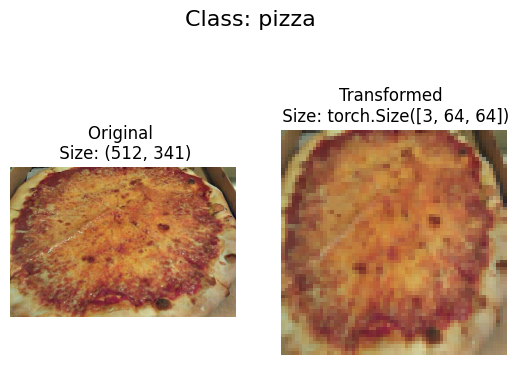

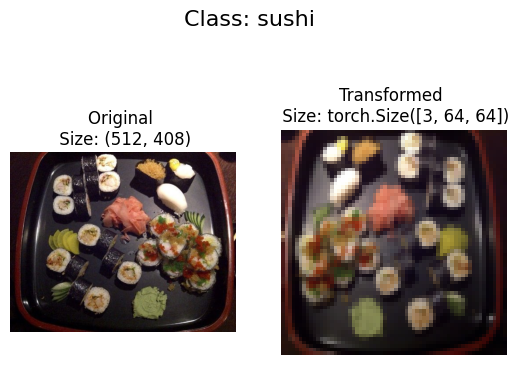

In [23]:
#Plotting transformed data
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f)
      ax[1].imshow(transformed_image.permute(1,2,0))
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform, n=3)

*ImageFolder*

In [24]:
#Loading and transforming data with ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

In [25]:
#Getting informations
class_names = train_data.classes
class_dict = train_data.class_to_idx

class_names, class_dict, len(train_data), len(test_data)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}, 225, 75)

In [27]:
#Plotting transformed data
img, label = train_data[0]
img.permute(1,2,0)

print(f"Image shape: {img.shape}")
print(f"Label: {label} ({class_names[label]})")
print(f"Image datatype: {img.dtype}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Label: 0 (pizza)
Image datatype: torch.float32
Label datatype: <class 'int'>


(-0.5, 63.5, 63.5, -0.5)

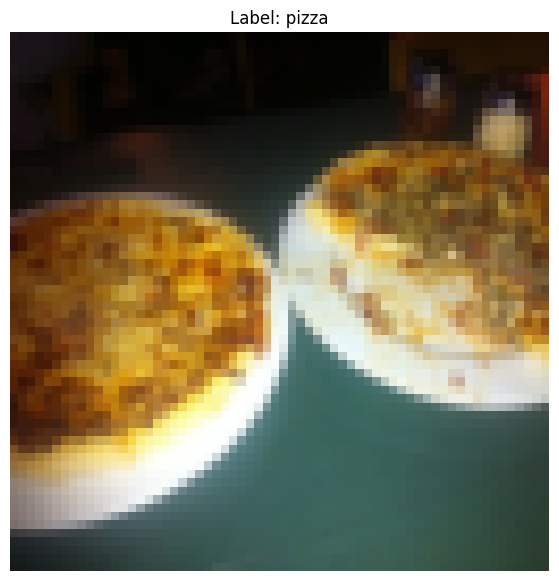

In [28]:
#Visualizing image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.title(f"Label: {class_names[label]}")
plt.axis("off")

**4) Data into dataloader**

In a dataloader the dataset is divided into mini-batches, we can easily iterate through it.

In [29]:
#Dataset into dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [30]:
#Batch visualizing
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


# **Creating a Custom Image Dataset**

To create our custom dataset we have to:
1. Subclass torch.utilis.data.Dataset
2. Initializing the subclass with the directory with the data
3. Initializing the subclass with the desired transformation if required
4. Create the attributes:
  - paths
  - transform
  - classes
  - class_to_idx
5. Create / overwrite the functions:
  - load_images()
  - len()
  - getitem()

**Custom dataset creation**

In [42]:
# Make function to find classes in target directory
def find_classes(directory: str):
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [43]:
from torch.utils.data import Dataset
from pathlib import Path

class CustomImageDataset(Dataset):
  def __init__(self, target_dir, transform=None):
    self.paths = list(Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(target_dir)

  def load_images(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    img = self.load_images(index)
    class_name = self.paths[index].parent.stem
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx



In [44]:
#Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
  ])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
  ])

In [45]:
#Testing the custom dataset loader
train_data_custom = CustomImageDataset(train_dir, transform=train_transforms)
test_data_custom = CustomImageDataset(test_dir, transform=test_transforms)

**Visualizing elements of the custom dataset**

In [46]:
#Make function to display random images
def display_random_images(dataset, classes = None, num_images=5, display_shape = True, seed=None):
  if seed:
    random.seed(seed)

  if num_images > 10:
    num_images = 10
    display_shape = False

  random_samples_idx = random.sample(range(len(dataset)), k=num_images)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, num_images, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\n Shape: {targ_image_adjust.shape}"
      plt.title(title)

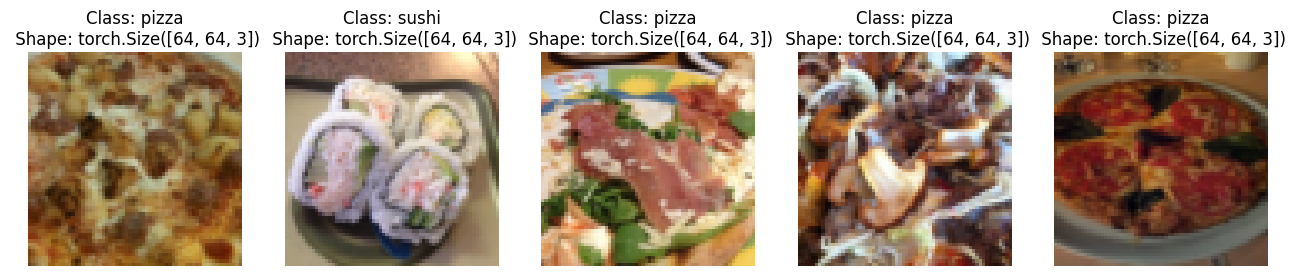

In [47]:
#Display random images from ImageFolder dataset
display_random_images(train_data, num_images= 5, classes= class_names, seed = None)

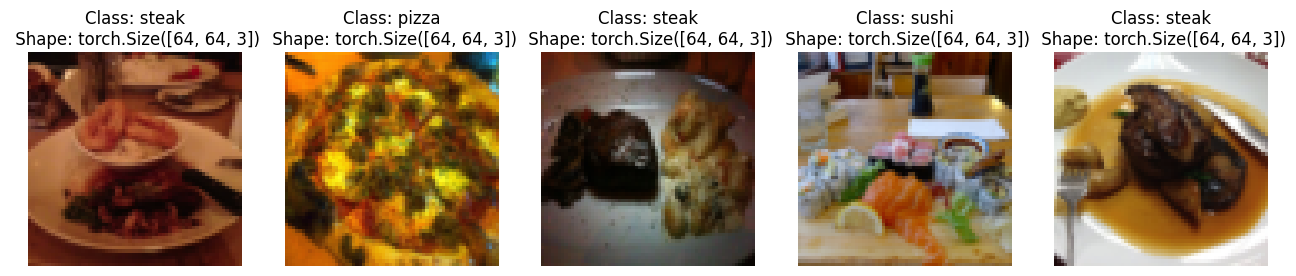

In [48]:
#Display random images from Custom dataset
display_random_images(test_data_custom, num_images= 5, classes= class_names, seed = None)

**Turn custom dataset images into dataloader**

In [49]:
#Creating dataloader
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [50]:
img_custom, label_custom = next(iter(train_dataloader_custom))
print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


# **Data Augmentation**

Data augmentation is the process of artificially adding diversity to our training data.

We apply various image transformations to the training images.

*trivial augmentation*

In [51]:
#Trivial augmentation
from torchvision import transforms

train_transform1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
  ])

test_transform1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
  ])

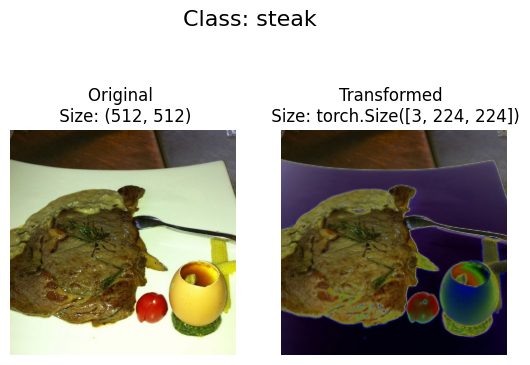

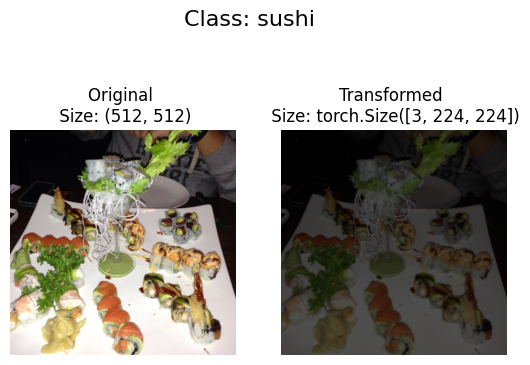

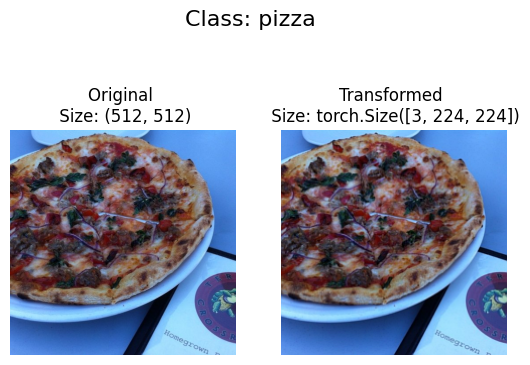

In [53]:
#Plotting transformed images
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_path_list, train_transform1, n=3)

*color jitter augmentation*

In [54]:
#ColorJitter augmentation
from torchvision import transforms

train_transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(),
    transforms.ToTensor()
  ])

test_transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
  ])

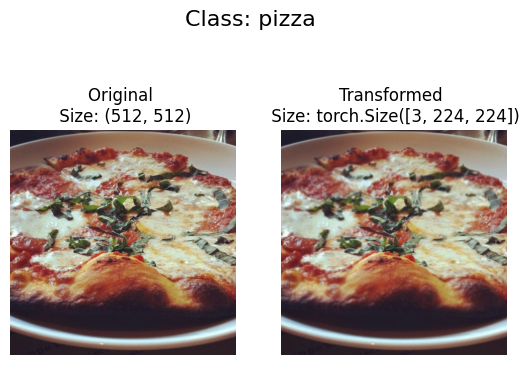

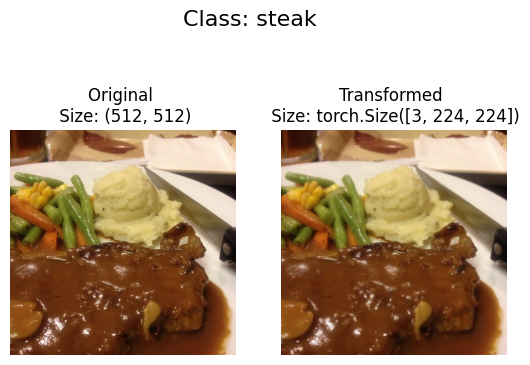

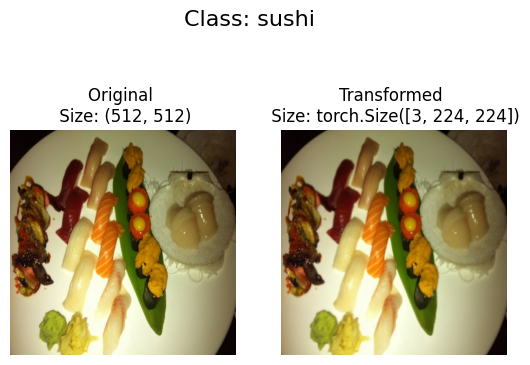

In [56]:
#Plotting transformed images
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_path_list, train_transform2, n=3)

# **Model performance on custom data**

*no transformation*

**1) Data loading and transformation**

In [113]:
#Create simple transformation
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [114]:
#Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(test_dir, transform=simple_transform)

In [115]:
#Dataset to dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

**2) Model building**

In [116]:
#Model building
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model8 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model8

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [117]:
!pip install torchinfo

In [118]:
#Getting model informations
from torchinfo import summary

summary(model8, input_size=(BATCH_SIZE, 3, 64, 64), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
TinyVGG                                  [32, 3, 64, 64]      [32, 3]              --                   True
├─Sequential: 1-1                        [32, 3, 64, 64]      [32, 10, 32, 32]     --                   True
│    └─Conv2d: 2-1                       [32, 3, 64, 64]      [32, 10, 64, 64]     280                  True
│    └─ReLU: 2-2                         [32, 10, 64, 64]     [32, 10, 64, 64]     --                   --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]     [32, 10, 64, 64]     910                  True
│    └─ReLU: 2-4                         [32, 10, 64, 64]     [32, 10, 64, 64]     --                   --
│    └─MaxPool2d: 2-5                    [32, 10, 64, 64]     [32, 10, 32, 32]     --                   --
├─Sequential: 1-2                        [32, 10, 32, 32]     [32, 10, 16, 16]     --                   True
│    └─Conv2d: 2-6  

**3) Training and testing model**

We want to create functions to train and test every model

In [119]:
#Creating training and testing loop functions
def train_step(model, dataloader, loss_fn, optimizer, device = device):
  model.train()

  train_loss, train_acc = 0, 0
  for batch, (X,Y) in enumerate(dataloader):
    X, Y = X.to(device), Y.to(device)

    Y_pred = model(X)

    loss = loss_fn(Y_pred, Y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    Y_pred_class = torch.argmax(torch.softmax(Y_pred, dim=1), dim=1)
    train_acc += (Y_pred_class == Y).sum().item()/len(Y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc



def test_step(model, dataloader, loss_fn, device = device):
  model.eval()

  test_loss, test_acc = 0 , 0

  with torch.inference_mode():
    for batch, (X,Y) in enumerate(dataloader):
      X, Y = X.to(device), Y.to(device)

      Y_pred = model(X)

      loss = loss_fn(Y_pred, Y)
      test_loss += loss.item()

      Y_pred_class = Y_pred.argmax(dim=1)
      test_acc += (Y_pred_class == Y).sum().item()/len(Y_pred)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [120]:
#Creating a function to loop on epochs
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs = 5, device = device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    print(f"Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [121]:
#Training and evaluating model8
torch.manual_seed(42)

NUM_EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model8.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model8_results = train(model8, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1071 | train_acc: 0.2500 | test_loss: 1.1061 | test_acc: 0.2604
Epoch: 1 | train_loss: 1.0784 | train_acc: 0.4258 | test_loss: 1.1396 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0804 | train_acc: 0.4258 | test_loss: 1.1698 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1282 | train_acc: 0.3047 | test_loss: 1.1594 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0889 | train_acc: 0.4258 | test_loss: 1.1443 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0962 | train_acc: 0.3047 | test_loss: 1.1456 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0850 | train_acc: 0.4336 | test_loss: 1.1422 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.0954 | train_acc: 0.2930 | test_loss: 1.1466 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.0872 | train_acc: 0.3711 | test_loss: 1.1109 | test_acc: 0.3210
Epoch: 9 | train_loss: 1.0353 | train_acc: 0.4727 | test_loss: 1.0373 | test_acc: 0.5256
Epoch: 10 | train_loss: 0.9539 | train_acc: 0.6211 | test_loss: 1.0586 | test_acc: 0.3428
Epoch: 11 | train_lo

Model is working pretty bad

**4) Model evaluating**

In [122]:
#Function to plot loss curves
def plot_loss_curves(results):

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

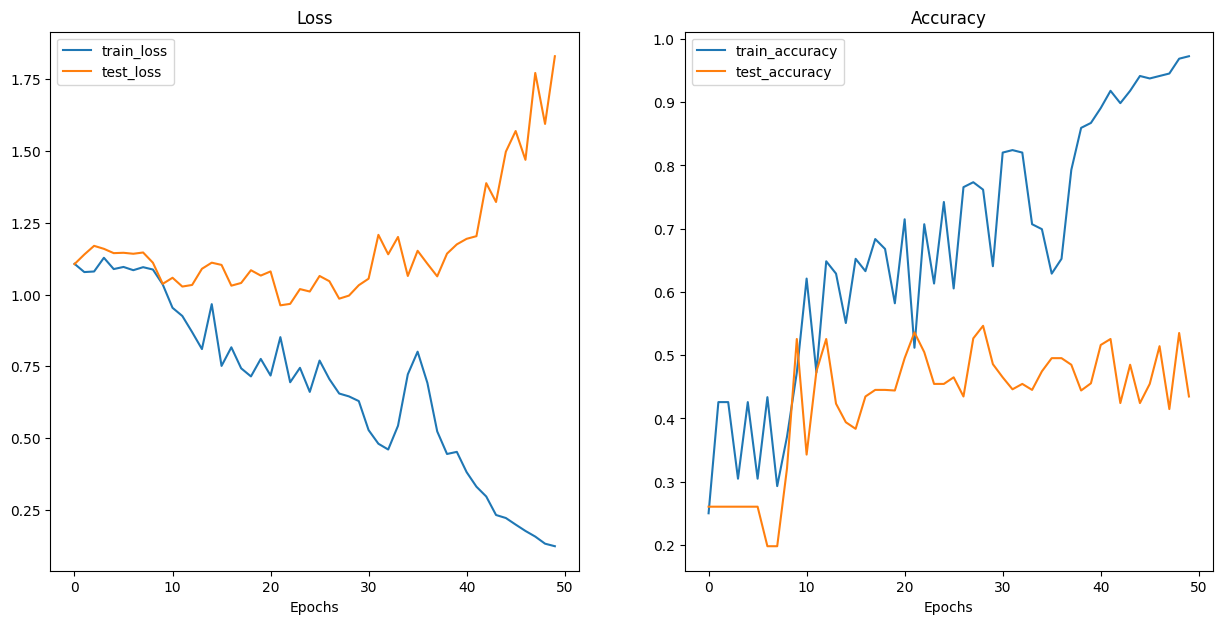

In [123]:
#Plotting loss curves of model8
plot_loss_curves(model8_results)

Example of overfitting (train loss decreases and test loss increases)

*transformation*

**1) Data loading and transformation**

In [124]:
#Trivial data augmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
                                              transforms.Resize((64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                              transforms.ToTensor()
                                              ])
test_transform_trivial = transforms.Compose([
                                             transforms.Resize((64,64)),
                                             transforms.ToTensor()
                                             ])

In [125]:
#Dataset creation
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform_trivial)

In [126]:
#Dataset into dataloader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

**2) Model building**

In [127]:
#Creating model9
model9 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
model9

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

**3) Model training and testing**

In [128]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model9.parameters(), lr=0.001)

In [129]:
#Training and testing model
from timeit import default_timer as timer
NUM_EPOCHS = 50

start_time = timer()

model9_results = train(model9, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.0993 | train_acc: 0.2305 | test_loss: 1.0934 | test_acc: 0.2604
Epoch: 1 | train_loss: 1.1006 | train_acc: 0.3047 | test_loss: 1.1005 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0947 | train_acc: 0.4258 | test_loss: 1.0980 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1058 | train_acc: 0.3047 | test_loss: 1.1011 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0905 | train_acc: 0.4258 | test_loss: 1.1038 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0970 | train_acc: 0.3047 | test_loss: 1.1087 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0961 | train_acc: 0.3047 | test_loss: 1.1091 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0883 | train_acc: 0.4727 | test_loss: 1.1088 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.0979 | train_acc: 0.3203 | test_loss: 1.1193 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.0853 | train_acc: 0.4297 | test_loss: 1.1210 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.0780 | train_acc: 0.4258 | test_loss: 1.1395 | test_acc: 0.2604
Epoch: 11 | train_lo

**4) Model evaluating**

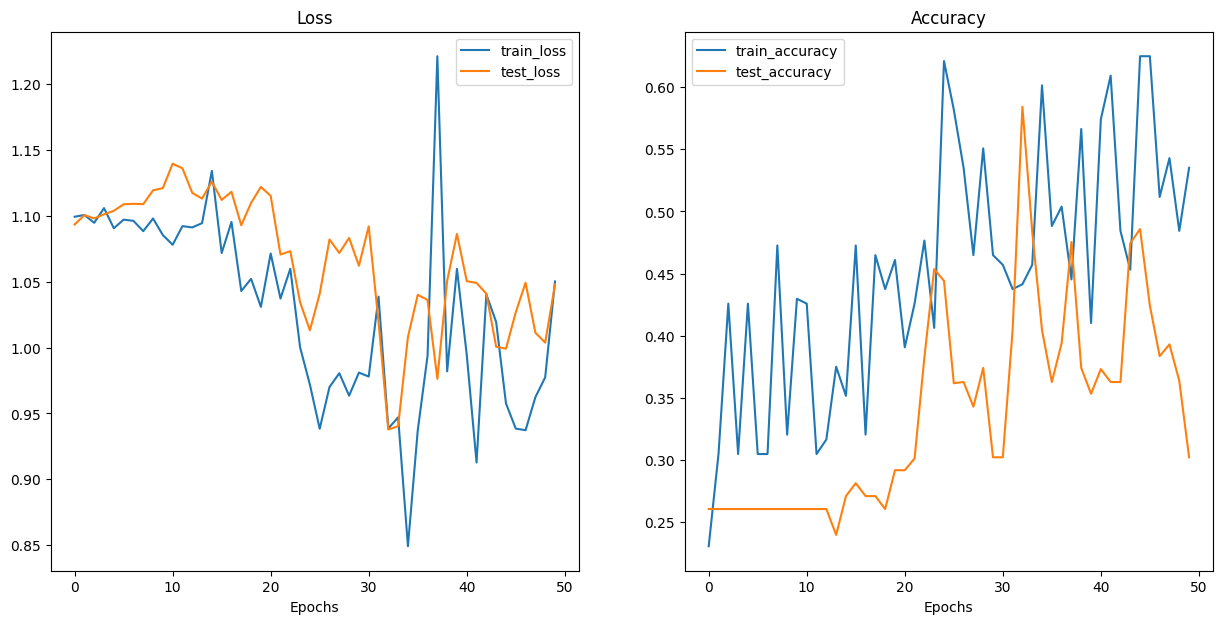

In [130]:
#Plotting loss curve of model 9
plot_loss_curves(model9_results)

Example of underfitting (train loss and test loss curves remains high)

**Comparing results of model8 and model9**

In [131]:
import pandas as pd
model8_df = pd.DataFrame(model8_results)
model9_df = pd.DataFrame(model9_results)

Text(0.5, 1.0, 'Test accuracy')

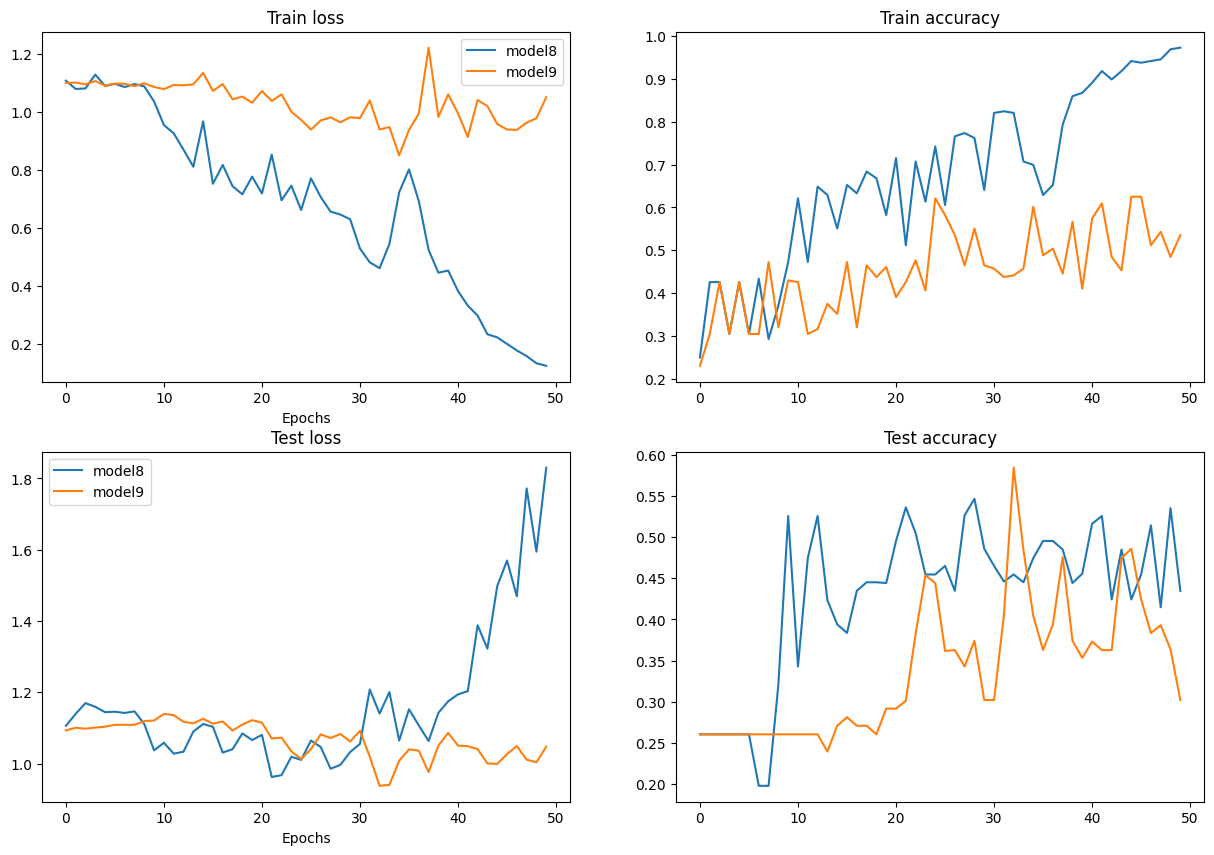

In [132]:
plt.figure(figsize=(15,10))
epochs = range(len(model8_df))

plt.subplot(2,2,1)
plt.plot(epochs, model8_df["train_loss"], label="model8")
plt.plot(epochs, model9_df["train_loss"], label="model9")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model8_df["train_acc"], label="model8")
plt.plot(epochs, model9_df["train_acc"], label="model9")
plt.title("Train accuracy")

plt.subplot(2,2,3)
plt.plot(epochs, model8_df["test_loss"], label="model8")
plt.plot(epochs, model9_df["test_loss"], label="model9")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model8_df["test_acc"], label="model8")
plt.plot(epochs, model9_df["test_acc"], label="model9")
plt.title("Test accuracy")


**Making a prediction from an image out of the dataset**

In [134]:
#Importing an image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/05-custom-image.jpg")
   f.write(request.content)
else:
  print("Custom image already downloaded")